In [1]:
%pylab inline

import anacal
import numpy as np
import matplotlib.pylab as plt

import lsst.geom as geom
from lsst.afw.geom import makeSkyWcs

from xlens.simulator.multiband import (
    MultibandSimShearTaskConfig,
    MultibandSimShearTask,
)

from astropy.visualization import simple_norm

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
config = MultibandSimShearTaskConfig()
config.survey_name = (
    "lsst"  # The scale parameter needs to be consistent with scale
)
pixel_scale = 0.2  # pixel scale of the survey
mag_zero = 30.0
dim = 500

bbox = geom.Box2I(
    minimum=geom.Point2I(x=0, y=0),
    maximum=geom.Point2I(x=dim - 1, y=dim - 1),
)
cd_matrix = np.array([[-1.0, -0.0], [0.0, 1.0]]) * (pixel_scale / 3600.0)

crval = geom.SpherePoint(
    np.pi / 2.0,  # radians
    0.0,  # radians
    geom.radians,
)

stack_crpix = geom.Point2D(
    (dim - 1) / 2.0,
    (dim - 1) / 2.0,
)

wcs_stack = makeSkyWcs(
    crpix=stack_crpix,
    crval=crval,
    cdMatrix=cd_matrix,
)

Text(0.5, 1.0, 'Exposure')

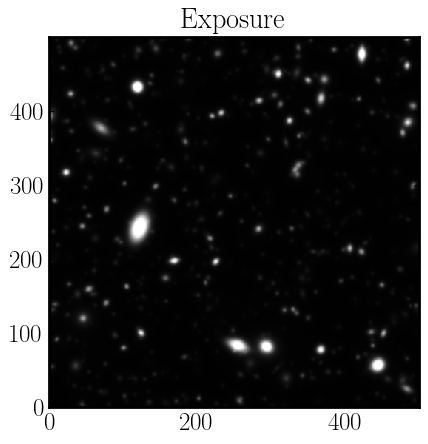

In [3]:
sim_task = MultibandSimShearTask(config=config)
outcome = sim_task.run(band="i", seed=0, boundaryBox=bbox, wcs=wcs_stack)
gal_array = np.asarray(
    outcome.outputExposure.getMaskedImage().getImage().array,
    np.float64,
)
lsst_psf = outcome.outputExposure.getPsf()
xc = int(dim // 2)  # we need PSF model without subpixel offset
yc = int(dim // 2)
psf_array = np.asarray(
    anacal.utils.resize_array(
        lsst_psf.computeImage(geom.Point2D(xc, yc)).getArray(), (64, 64)
    ),
    dtype=np.float64,
)


# Display the galaxy image simulation
plt.imshow(
    gal_array,
    aspect="equal",
    cmap="Greys_r",
    origin="lower",
    interpolation="None",
    norm=simple_norm(gal_array, "asinh", asinh_a=0.2, min_cut=-0.1, max_cut=30),
)
plt.title("Exposure")

Text(0.5, 1.0, 'PSF')

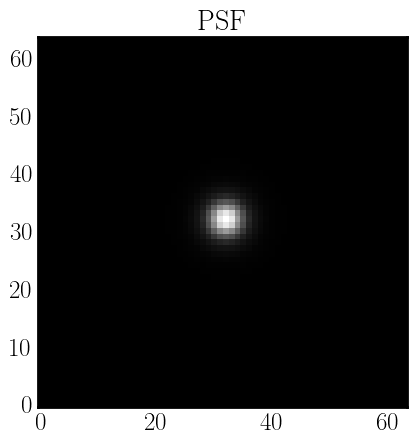

In [4]:
plt.close()
# Display the PSF image simulation
plt.imshow(psf_array, cmap="Greys_r", origin="lower")
plt.title("PSF")

In [5]:
# Run Anacal measurement
fpfs_config = anacal.fpfs.FpfsConfig(
    sigma_arcsec=0.52,  # base measruement kernel (for detection and e1, e2, q1, q2)
    sigma_arcsec1=0.45,  # kernel 1 (for e1_1, e2_1, q1_1, q2_1)
    sigma_arcsec2=0.55,  # kernel 2 (for e1_2, e2_2, q1_2, q2_2)
)
noise_variance = 0.37
out = anacal.fpfs.process_image(
    fpfs_config=fpfs_config,
    mag_zero=mag_zero,
    gal_array=gal_array,
    psf_array=psf_array,
    pixel_scale=pixel_scale,
    noise_variance=noise_variance,  # the detection threshold is determined from this (do not set it to zero)
    noise_array=None,  # image is noiseless, set it to None
    detection=None,  # if set to None, anacal will do detection
)

Text(0.5, 1.0, 'Exposure')

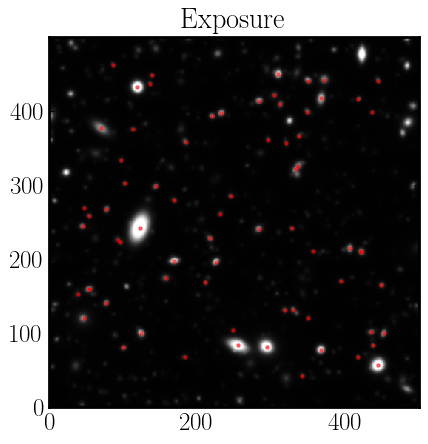

In [6]:
plt.close()
plt.scatter(out["x"], out["y"], marker="o", alpha=0.5, s=5.0, color="red")
# Display the galaxy image simulation
plt.imshow(
    gal_array,
    aspect="equal",
    cmap="Greys_r",
    origin="lower",
    interpolation="None",
    norm=simple_norm(gal_array, "asinh", asinh_a=0.2, min_cut=-0.1, max_cut=30),
)
plt.title("Exposure")

In [7]:
out.dtype.names

('y',
 'x',
 'is_peak',
 'mask_value',
 'e1',
 'e1_g1',
 'e2',
 'e2_g2',
 'q1',
 'q1_g1',
 'q2',
 'q2_g2',
 'w',
 'w_g1',
 'w_g2',
 'e1_1',
 'e1_g1_1',
 'e2_1',
 'e2_g2_1',
 'q1_1',
 'q1_g1_1',
 'q2_1',
 'q2_g2_1',
 'e1_2',
 'e1_g1_2',
 'e2_2',
 'e2_g2_2',
 'q1_2',
 'q1_g1_2',
 'q2_2',
 'q2_g2_2')

In [8]:
# base kernel scale
e1 = out["w"] * out["e1"]
e1g1 = out["w_g1"] * out["e1"] + out["w"] * out["e1_g1"]
print(np.sum(e1) / np.sum(e1g1))

# kernel 1
e1 = out["w"] * out["e1_1"]
e1g1 = out["w_g1"] * out["e1_1"] + out["w"] * out["e1_g1_1"]
print(np.sum(e1) / np.sum(e1g1))

# kernel 2
e1 = out["w"] * out["e1_2"]
e1g1 = out["w_g1"] * out["e1_2"] + out["w"] * out["e1_g1_2"]
print(np.sum(e1) / np.sum(e1g1))

-0.088351884772764
-0.0815487863732862
-0.09107406295652219
